## Settings

In [1]:
from typing import Any, Dict, List, OrderedDict, Union
import os
from os.path import join as osj
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib.collections import LineCollection
import random
import pandas as pd
from workoutdetector.dataset import FrameDataset, build_test_transform, RepcountHelper
from workoutdetector.utils import plot_all, plt_params, plot_per_action, parse_json
import json
from workoutdetector.time_series import reps_to_label

CLASSES = ['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']

COLORS = list(plt.get_cmap('tab20').colors)

params = {
    'figure.dpi': 300,
    'figure.figsize': (8, 5),
    'figure.autolayout': True,
    'lines.linewidth': 1,
    'axes.prop_cycle': plt.cycler('color', COLORS),
    'font.size': 10,
    'font.family': 'monospace',
}


In [2]:
data_root = os.path.expanduser("~/data/RepCount")
anno_path = osj(data_root, "annotation.csv")
helper = RepcountHelper(data_root, anno_path)
CLASSES = helper.classes
print(CLASSES)
data = list(helper.get_rep_data(['train', 'val', 'test'], ['all']).values())

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']


In [3]:
json_dir = os.path.expanduser('~/projects/WorkoutDetector/out/acc_0.841_epoch_26_20220711-191616_1x1')
json_files = os.listdir(json_dir)
template  = '{}.stride_1_step_1.json'
print(len(json_files))
print(json_files[0])
print(json.load(open(osj(json_dir, json_files[0]))).keys())

762
stu7_51.mp4.stride_1_step_1.json
dict_keys(['video_name', 'model', 'stride', 'step', 'length', 'fps', 'input_shape', 'checkpoint', 'total_frames', 'ground_truth', 'action', 'scores'])


video: stu7_70.mp4
class: squat
count: 6
reps: [149, 218, 218, 271, 271, 328, 704, 772, 773, 820, 821, 881]
fps: 25.0
total_frames: 950


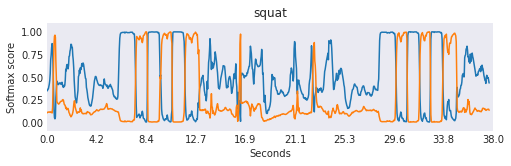

In [4]:
item = random.choice(data)
print(item)
js = json.load(open(osj(json_dir, template.format(item.video_name))))

# plot_all(js['ground_truth'], js, softmax=True, stride=1)
plot_per_action(js, softmax=True, action_only=True)

## Hidden Markov Model

- Input: A sequence of probabilities of shape (seq_len, 12)
- Output: An integer state

In [5]:
from hmmlearn import hmm
from workoutdetector.datasets import FeatureDataset
from workoutdetector.utils import pred_to_count
from workoutdetector.utils.eval import smooth_pred
from torch.utils.data import DataLoader

In [60]:
def train(action):
    feat_ds = FeatureDataset(json_dir, anno_path, 'train', action=action, window=1, stride=1)
    print(action, feat_ds.x.shape, 'num y', np.unique(feat_ds.y))
    # softmax_x = F.softmax(torch.from_numpy(feat_ds.x), dim=1).numpy()
    transmat, pi, means, cov = feat_ds.hmm_stats(feat_ds.x.numpy(), np.array(feat_ds.y), 'full')
    # print(transmat, pi, means, cov)
    n_states = len(np.unique(feat_ds.y))
    model = hmm.GaussianHMM(n_components=n_states, n_iter=300, covariance_type='full')
    model.transmat_ = transmat
    model.startprob_ = pi.T
    model.means_ = means
    model.covars_ = cov
    # softmax_x = F.softmax(torch.from_numpy(feat_ds.x.squeeze(1)), dim=1)
    # model.fit(feat_ds.x.numpy())
    return model


def hmm_infer(model, x, gt_reps, class_idx, window=1):
    gt_labels = reps_to_label(gt_reps, len(x), class_idx=class_idx) # set to 0 for 3 states
    y = model.predict(x)
    acc = (y == gt_labels[:len(y)]).sum() / len(gt_labels)
    gt_count = len(gt_reps) // 2
    pred_smoothed = smooth_pred(y-1, window=window) # minus 1 because no-class is 0
    count, reps = pred_to_count(pred_smoothed, stride=1*1, step=1) 
    diff = abs(count - gt_count)
    obo = 1 if (diff <= 1) else 0
    return obo, diff, acc,  reps

action = 'pull_up'
model = train(action)

pull_up torch.Size([85287, 1, 12]) num y [0 1 2]


In [93]:
action = 'push_up'
feat_ds = FeatureDataset(json_dir, anno_path, 'train',action=action, window=1, stride=10)
print(action, feat_ds.x.shape, 'num y', np.unique(feat_ds.y))
# softmax_x = F.softmax(torch.from_numpy(feat_ds.x), dim=1).numpy()
transmat, pi, means, cov = feat_ds.hmm_stats(feat_ds.x.numpy(), np.array(feat_ds.y), 'full')
# print(transmat, pi, means, cov)
n_states = len(np.unique(feat_ds.y))
model = hmm.GaussianHMM(n_components=n_states, n_iter=300, covariance_type='full')
model.startprob_ = pi
model.transmat_ = transmat
model.means_ = means
model.covars_ = cov
# model.fit(feat_ds.x.squeeze(1).numpy())
# models = [hmm.GMMHMM(n_components=n_states, n_iter=300, covariance_type='full', 
    # random_state=random.randint(0, 100)) for _ in range(5)]
# models_score = []
# for m in models:
    # m.transmat_ = transmat
    # m.startprob_ = pi.T
    # m.means_ = means
    # m.covars_ = cov
    # softmax_x = F.softmax(torch.from_numpy(feat_ds.x.squeeze(1)), dim=1)
    # m.fit(feat_ds.x.squeeze(1).numpy())
    # models_score.append(m.score(feat_ds.x.squeeze(1).numpy()))
# print(models_score)

# model = models[np.argmax(models_score)]    

push_up torch.Size([9113, 1, 12]) num y [0 1 2]


In [8]:
@matplotlib.rc_context(params)
def plot_pred_reps(result: List[int],
              gt: List[int],
              orig_reps: List[int],
              total_frames: int,
              fps: float,
              title: str,
              step: int = 8,
              show: bool = True,
              save_path: str = None) -> None:
    video_len = total_frames / fps
    max_num_ticks = 10
    plt.figure(figsize=(7, 2))
    plt.xlabel('Second', fontsize=10)
    plt.yticks([])
    plt.ylim(0, 1)
    offset = total_frames // 10
    plt.xlim(-offset * 1.1, total_frames + 5)
    h = 0.2
    plt.xticks(np.linspace(0, total_frames, max_num_ticks),
               np.round(np.linspace(0.0, video_len, max_num_ticks), 2), fontsize=10)
    # background
    rect = plt.Rectangle((0, h), total_frames, 0.6, color='w')
    plt.gca().add_patch(rect)
    for i in range(0, len(gt), 2):
        rect = plt.Rectangle((gt[i], 0.6), (gt[i + 1] - gt[i]), h, color='C1')
        plt.gca().add_patch(rect)
    plt.vlines(gt, color='C0', linewidth=2, ymin=0.6, ymax=0.8)
    for j in range(0, len(result), 2):
        rect = plt.Rectangle((result[j], 0.4), (result[j + 1] - result[j]),
                             h - 0.01,
                             color='C2')
        plt.gca().add_patch(rect)
    for i in range(0, len(orig_reps), 2):
        rect = plt.Rectangle((orig_reps[i], 0.2), (orig_reps[i + 1] - orig_reps[i]),
                             h - 0.01,
                             color='C5')
        plt.gca().add_patch(rect)
    plt.title(title)
    plt.text(-offset, 0.65, 'True', color='C0', fontsize=9)
    plt.text(-offset, 0.45, 'HMM', color='C2', fontsize=9)
    plt.text(-offset, 0.25, 'Argmax', color='C4', fontsize=9)
    if show:
        plt.show()
    if save_path is not None:
        plt.savefig(save_path)
    plt.close()

In [113]:
@matplotlib.rc_context(params)
def plot_raw_output(val_x, val_y, pred, baseline, class_idx):
    fig, ax = plt.subplots(4, 1, figsize=(7,4), dpi=400)
    ax[0].plot(pred, 'C2', label='HMM')
    ax[1].plot(val_y, 'C0', label='true')
    for i in range(4):
        if i != 2:
            ax[i].set_ylim(-0.1, 2.1)
        if i < 3:
            ax[i].set_xticks([])
    ax[0].text(-len(val_y)*0.15, 1 ,'HMM', color='C2', fontsize=9)
    ax[1].text(-len(val_y)*0.15, 1 ,'True', color='C0', fontsize=9)
    ax[2].text(-len(val_y)*0.15, 1 ,'Input', fontsize=9)
    ax[3].text(-len(val_y)*0.15, 1 ,'Argmax', color='C12', fontsize=9)
    colors = ['C15'] * val_x.shape[1]
    colors[class_idx*2:class_idx*2+2] = ['C0', 'C2']
    for i, line in enumerate(val_x.T):
        ax[2].plot(line, color=colors[i], alpha=0.8)

    ax[3].plot(baseline, 'C12', label='Argmax')
    ax[-1].set_xlabel('Frame index')
    ax[0].set_title(f'{item.video_name} {item.class_}')
    plt.tight_layout()
    plt.show()

### Predict

(472, 12) [0 0 0 0 0 0 0 0 0 0]
startprob_ (3,)
count 3 name stu6_47.mp4 push_up
argmax_smoothed [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]


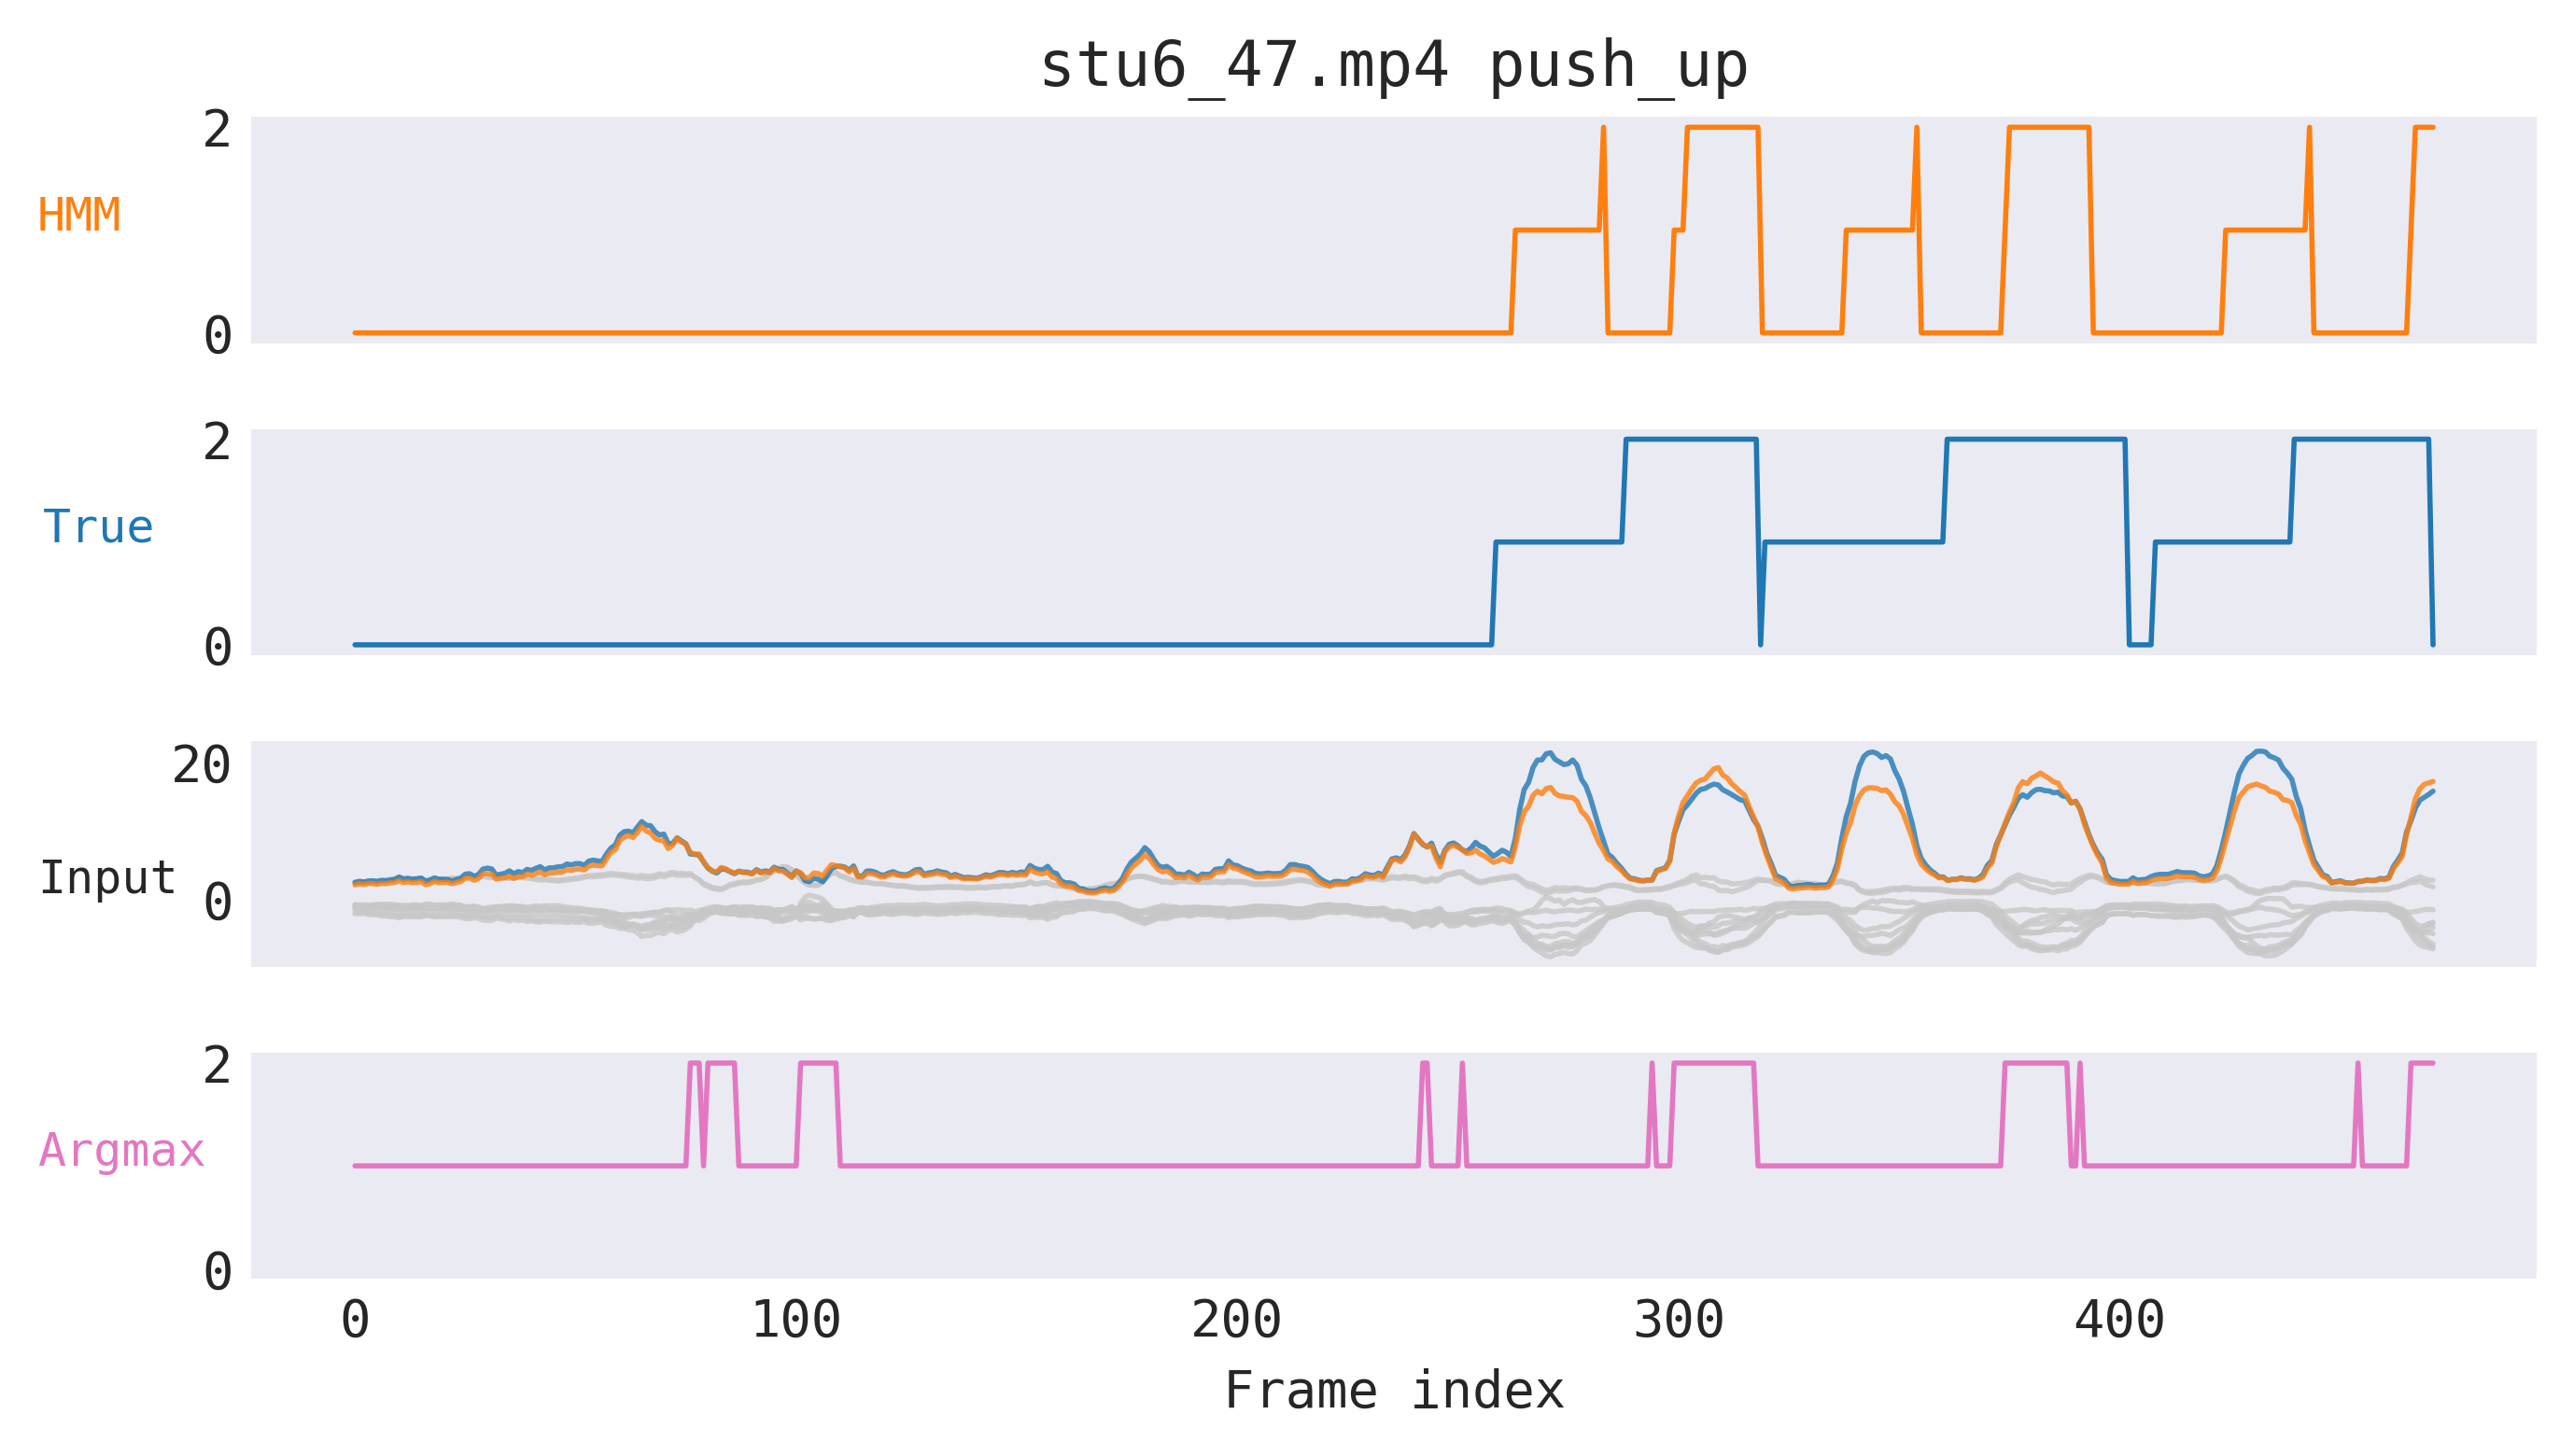

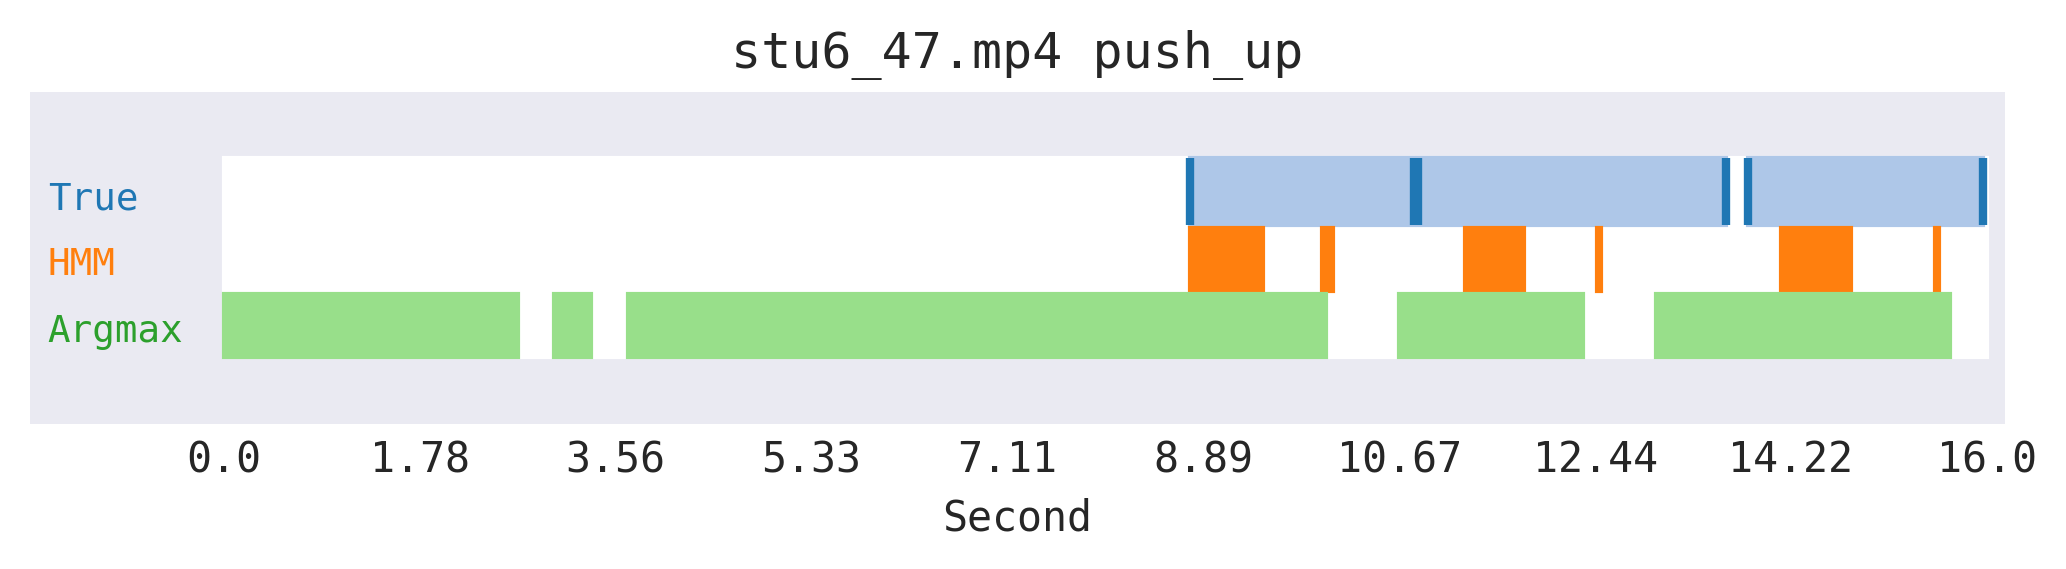

In [119]:
val_data = list(helper.get_rep_data(['val'], [action]).values())
item = random.choice(val_data)

val_x = []
js = json.load(open(osj(json_dir, template.format(item.video_name))))
for i,v in js['scores'].items():
    val_x.append(np.array(list(v.values())))
val_x = np.array(val_x)
class_idx = CLASSES.index(item.class_)
val_y = np.array(reps_to_label(item.reps, item.total_frames, class_idx=0))
print(val_x.shape, val_y[:10])
print('startprob_', model.startprob_.shape)
pred = model.predict(val_x)
print('count', len(js['ground_truth'])//2, 'name', item.video_name, item.class_)
pred_mapped = pred.copy()
# pred_mapped[pred == 0] = 1
pred_smoothed = smooth_pred(pred-1, window=1)
hmm_count, hmm_reps = pred_to_count(pred_smoothed, stride=1, step=1)
# print('hmm pred', pred)
# Baseline Argmax with threshold 0.6
threshold = 0.6
action_only_x = val_x[:, class_idx*2:class_idx*2+2]
val_x_thre = [np.argmax(vx) if vx.max() >= threshold else -1 for vx in action_only_x]
val_x_thre = np.array(val_x_thre) + 1
val_x_smoothed = smooth_pred(val_x_thre-1, window=10)
argmax_count, argmax_reps = pred_to_count(val_x_smoothed, stride=1*10, step=1)
print('argmax_smoothed', val_x_smoothed)

plot_raw_output(val_x, val_y, pred, val_x_thre, class_idx)
title = f'{item.video_name} {item.class_}'
plot_pred_reps(hmm_reps, js['ground_truth'], argmax_reps, item.total_frames, item.fps, title, step=1)

### Eval

In [65]:
smooth_params = {'front_raise': 1, 'situp': 1, 'pull_up': 5, 'push_up': 5, 'squat': 5, 'jump_jack': 5}

def eval_subset(model, split, action):
    test_data = list(helper.get_rep_data([split], [action]).values())
    total_obo, total_err, total_acc, gt_total_count = 0, 0, 0, 0
    for item in test_data:
        test_x = []
        js = json.load(open(osj(json_dir, template.format(item.video_name))))
        for i,v in js['scores'].items():
            test_x.append(np.array(list(v.values())))
        test_x = np.array(test_x)

        pred = model.predict(test_x)
        obo, err, acc, reps = hmm_infer(model, test_x, item.reps, 0, window=1)
        total_obo += obo
        total_err += err
        total_acc += acc
        gt_total_count += len(item.reps) // 2

    err_rate = total_err / len(test_data)
    acc_rate = total_acc / len(test_data)
    return dict(split=split, action=action, 
        OBO=total_obo, num_videos=len(test_data),
        MAE=err_rate, avg_count=gt_total_count/len(test_data), hmm_acc=acc_rate)

result = []
# model = train('all')
for action in CLASSES:
    model = train(action)
    for split in ['train', 'val', 'test']:
        result.append(eval_subset(model, split, action))

df = pd.DataFrame(result)
df_train = df[df.split == 'train']
df_val = df[df.split == 'val']
df_test = df[df.split == 'test']
all_obo = df.groupby('split').OBO.sum()
train_mae  = (df_train.MAE * df_train.num_videos).sum() / df_train.num_videos.sum()
val_mae = (df_val.MAE * df_val.num_videos).sum() / df_val.num_videos.sum()
test_mae = (df_test.MAE * df_test.num_videos).sum() / df_test.num_videos.sum()
all_num = df.groupby('split').num_videos.sum()
df_summary = pd.DataFrame({'split': ['train', 'val', 'test'],
    'MAE': [train_mae, val_mae, test_mae],
    'OBO': [all_obo['train'], all_obo['val'], all_obo['test']],
    'num_videos': [all_num['train'], all_num['val'], all_num['test']]})
print(df_summary.to_latex(index=False))
df.to_csv('hmm_result.csv')
print(df.to_latex(index=False))

situp torch.Size([88256, 1, 12]) num y [0 1 2]
push_up torch.Size([90525, 1, 12]) num y [0 1 2]
pull_up torch.Size([85287, 1, 12]) num y [0 1 2]
jump_jack torch.Size([57119, 1, 12]) num y [0 1 2]
squat torch.Size([87573, 1, 12]) num y [0 1 2]
front_raise torch.Size([54871, 1, 12]) num y [0 1 2]
\begin{tabular}{lrrr}
\toprule
split &      MAE &  OBO &  num\_videos \\
\midrule
train & 5.321101 &  189 &         545 \\
  val & 4.380000 &   36 &         100 \\
 test & 4.129310 &   54 &         116 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrrr}
\toprule
split &      action &  OBO &  num\_videos &      MAE &  avg\_count &  hmm\_acc \\
\midrule
train &       situp &   20 &          94 & 8.265957 &  12.553191 & 0.462475 \\
  val &       situp &    3 &          18 & 4.888889 &  14.888889 & 0.475111 \\
 test &       situp &    7 &          20 & 3.900000 &  13.500000 & 0.423883 \\
train &     push\_up &   27 &          87 & 5.413793 &  19.402299 & 0.550030 \\
  val &     push\_up &    6 & 